## [RAPIDS cuML Lasso](https://www.kaggle.com/code/cdeotte/rapids-cuml-lasso-lb-0-72500-cv-0-72800/notebook)

In this notebook, we show how to engineer order 2 and order 3 features for an order 1 model. Specifically we use RAPIDS cuML Lasso regression model which is linear. We engineer quadratic and cubic features to help Lasso model discover interactions between features. Furthermore, we display feature importance for Lasso interaction features to show which feature pairs and triplets contains the strongest patterns.

We encode categorical features with RAPIDS cuML TargetEncoder. RAPIDS cuML has all the functions from Scikit-Learn but uses GPU instead of CPU for accelerated speedup! And RAPIDS cuDF has all the functions from Pandas but uses GPU instead of CPU for accelearated speedup!

When we encode with Target Encoding, we are careful to prevent leaks. Specifically when using 5 folds, we need to compute TE 5 times. During each iteration of for fold in range(5), we fit_transform TE on train and then transform valid and test. 


In [1]:
import cudf, numpy as np
from cuml import Lasso
from cuml.preprocessing.TargetEncoder import TargetEncoder
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd

In [6]:
import os

os.getcwd()

'/mnt/d/personal/stuff/self-learn'

In [7]:
train = cudf.read_csv("eda/kaggle/playground/s4/e09/data/train.csv")
test = cudf.read_csv("eda/kaggle/playground/s4/e09/data/test.csv")

train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [9]:
# Binning [milage] values

train['milage'] = (train['milage'] // 1000) * 1000
test['milage'] = (test['milage'] // 1000) * 1000

train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143000,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136000,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19000,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7000,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Uni-grams

These are the original columns of train. We will treat them all as categorical.

In [10]:
COLS = train.columns[1:-1].tolist()

print(f"Uni-grams: {COLS}")

Uni-grams: ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


## Bi-grams

We create new categorical features by combining all pairs of original categorical features. There are 55 pairs.

In [11]:
train_cols = {}
test_cols = {}

COLS2 = []

for i, col1 in enumerate(COLS[:-1]):
    for j, col2 in enumerate(COLS[i + 1:]):
        key = col1 + '-' + col2
        train_cols[key] = train[col1].astype(str) + '_' + train[col2].astype(str)
        test_cols[key] = test[col1].astype(str) + '_' + test[col2].astype(str)

        COLS2.append(key)


print(len(COLS2))

55


## Tri-grams

We create new categorical features by combining all triplets of original categorical features. There are 165 triplets.

In [12]:
COLS3 = []

for i, col1 in enumerate(COLS[:-2]):
    for j, col2 in enumerate(COLS[i + 1: -1]):
        for k, col3 in enumerate(COLS[i + j + 2:]):
            key = '-'.join([col1, col2, col3])
            train_cols[key] = train[col1].astype(str) + '_' + train[col2].astype(str) + '_' + train[col3].astype(str)
            test_cols[key] = test[col1].astype(str) + '_' + test[col2].astype(str) + '_' + test[col3].astype(str)

            COLS3.append(key)

print(f"Tri-grams have {len(COLS3)} columns: {COLS3}")

Tri-grams have 165 columns: ['brand-model-model_year', 'brand-model-milage', 'brand-model-fuel_type', 'brand-model-engine', 'brand-model-transmission', 'brand-model-ext_col', 'brand-model-int_col', 'brand-model-accident', 'brand-model-clean_title', 'brand-model_year-milage', 'brand-model_year-fuel_type', 'brand-model_year-engine', 'brand-model_year-transmission', 'brand-model_year-ext_col', 'brand-model_year-int_col', 'brand-model_year-accident', 'brand-model_year-clean_title', 'brand-milage-fuel_type', 'brand-milage-engine', 'brand-milage-transmission', 'brand-milage-ext_col', 'brand-milage-int_col', 'brand-milage-accident', 'brand-milage-clean_title', 'brand-fuel_type-engine', 'brand-fuel_type-transmission', 'brand-fuel_type-ext_col', 'brand-fuel_type-int_col', 'brand-fuel_type-accident', 'brand-fuel_type-clean_title', 'brand-engine-transmission', 'brand-engine-ext_col', 'brand-engine-int_col', 'brand-engine-accident', 'brand-engine-clean_title', 'brand-transmission-ext_col', 'brand-

In [14]:
ntrain = cudf.concat([train, cudf.DataFrame(train_cols)], axis=1)
ntest = cudf.concat([test, cudf.DataFrame(test_cols)], axis=1)

ntrain.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,transmission-ext_col-int_col,transmission-ext_col-accident,transmission-ext_col-clean_title,transmission-int_col-accident,transmission-int_col-clean_title,transmission-accident-clean_title,ext_col-int_col-accident,ext_col-int_col-clean_title,ext_col-accident-clean_title,int_col-accident-clean_title
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,A/T_Yellow_Gray,A/T_Yellow_None reported,A/T_Yellow_Yes,A/T_Gray_None reported,A/T_Gray_Yes,A/T_None reported_Yes,Yellow_Gray_None reported,Yellow_Gray_Yes,Yellow_None reported_Yes,Gray_None reported_Yes
1,1,Lincoln,LS V8,2002,143000,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,A/T_Silver_Beige,A/T_Silver_At least 1 accident or damage reported,A/T_Silver_Yes,A/T_Beige_At least 1 accident or damage reported,A/T_Beige_Yes,A/T_At least 1 accident or damage reported_Yes,Silver_Beige_At least 1 accident or damage rep...,Silver_Beige_Yes,Silver_At least 1 accident or damage reported_Yes,Beige_At least 1 accident or damage reported_Yes
2,2,Chevrolet,Silverado 2500 LT,2002,136000,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,A/T_Blue_Gray,A/T_Blue_None reported,A/T_Blue_Yes,A/T_Gray_None reported,A/T_Gray_Yes,A/T_None reported_Yes,Blue_Gray_None reported,Blue_Gray_Yes,Blue_None reported_Yes,Gray_None reported_Yes
3,3,Genesis,G90 5.0 Ultimate,2017,19000,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,...,Transmission w/Dual Shift Mode_Black_Black,Transmission w/Dual Shift Mode_Black_None repo...,Transmission w/Dual Shift Mode_Black_Yes,Transmission w/Dual Shift Mode_Black_None repo...,Transmission w/Dual Shift Mode_Black_Yes,Transmission w/Dual Shift Mode_None reported_Yes,Black_Black_None reported,Black_Black_Yes,Black_None reported_Yes,Black_None reported_Yes
4,4,Mercedes-Benz,Metris Base,2021,7000,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,...,7-Speed A/T_Black_Beige,7-Speed A/T_Black_None reported,7-Speed A/T_Black_Yes,7-Speed A/T_Beige_None reported,7-Speed A/T_Beige_Yes,7-Speed A/T_None reported_Yes,Black_Beige_None reported,Black_Beige_Yes,Black_None reported_Yes,Beige_None reported_Yes


## Features

We will target encode all 231 features (i.e. 11 uni-grams, 55 bi-grams, 165 tri-grams). Here we just create columns with zeros as placeholders for TE. Then during our 5 fold iterations, we will fit_transform train and transform valid and test. Computing TE 5 times for each of our 5 Kfolds prevents target leaks.


In [16]:
TARGET = 'price'
TE_COLS = [col + '-TE' for col in COLS + COLS2 + COLS3]

extra_cols = cudf.DataFrame(data=np.zeros((len(ntrain), len(TE_COLS))), columns=TE_COLS)
ntrain = cudf.concat([ntrain, extra_cols], axis=1)

extra_cols = cudf.DataFrame(data=np.zeros((len(ntest), len(TE_COLS))), columns=TE_COLS)
ntest = cudf.concat([ntest, extra_cols], axis=1)

ntrain.shape, ntest.shape

((188533, 464), (125690, 463))

In [17]:
ntrain.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,transmission-ext_col-int_col-TE,transmission-ext_col-accident-TE,transmission-ext_col-clean_title-TE,transmission-int_col-accident-TE,transmission-int_col-clean_title-TE,transmission-accident-clean_title-TE,ext_col-int_col-accident-TE,ext_col-int_col-clean_title-TE,ext_col-accident-clean_title-TE,int_col-accident-clean_title-TE
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Lincoln,LS V8,2002,143000,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Chevrolet,Silverado 2500 LT,2002,136000,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Lasso 5 Folds

We target encode all features using RAPIDS cuML TargetEncoder. During each iteration of our five KFold for-loops, we compute TE from that specific KFold train data with fit_transform and then transform the KFold valid data. Note that we **do not** compute TE once on the entire train.csv dataframe before KFold for-loops. Instead we compute TE five times during our five KFold folds. This *prevents leaks* in our CV.


In [20]:
from tqdm import tqdm

FOLDS = 5
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof, pred = np.zeros(len(ntrain)), np.zeros(len(ntest))

for i, (train_idx, test_idx) in enumerate(tqdm(kf.split(ntrain))):

    if not i % FOLDS: print()
    print("#" * 25)
    print(f"### FOLD {i + 1} ###")
    print("#" * 25)


    X_train = ntrain.iloc[train_idx,].copy()
    y_train = ntrain[TARGET].iloc[train_idx]

    X_val = ntrain.iloc[test_idx,].copy()
    y_val = ntrain[TARGET].iloc[test_idx]

    X_test = ntest.copy()

    for j, col in tqdm(enumerate(TE_COLS)):
        c = col.replace("-TE", "")

        enc_auto = TargetEncoder(
                    smooth=5,
                    split_method='random',
                    seed=42,
                    stat='mean',
                    n_folds=5
        )

        X_train[col] = enc_auto.fit_transform(X_train[[c]], y_train)
        X_val[col] = enc_auto.transform(X_val[[c]])
        X_test[col] = enc_auto.transform(X_test[[c]])

        avg = X_train[col].mean()
        std = X_train[col].std()

        X_train[col] = (X_train[col] - avg) / std
        X_val[col] = (X_val[col] - avg) / std
        X_test[col] = (X_test[col] - avg) / std
    
    
    X_train = X_train[TE_COLS]
    X_val = X_val[TE_COLS]
    X_test = X_test[TE_COLS]


    model = Lasso(alpha=1e2)
    model.fit(X_train, y_train)


    oof[test_idx] =  model.predict(X_val).to_numpy()

    if not i:
        pred = model.predict(X_test).to_numpy()
    else:
        pred += model.predict(X_test).to_numpy()

# Compute the average of all predictions made
pred /= FOLDS

0it [00:00, ?it/s]


#########################
### FOLD 1 ###


231it [01:31,  2.51it/s]
1it [01:40, 100.58s/it]

#########################
### FOLD 2 ###


231it [01:43,  2.24it/s]
2it [03:33, 107.86s/it]

#########################
### FOLD 3 ###


231it [01:30,  2.56it/s]
3it [05:16, 105.43s/it]

#########################
### FOLD 4 ###


231it [01:30,  2.56it/s]
4it [07:03, 106.33s/it]

#########################
### FOLD 5 ###


231it [01:31,  2.54it/s]
5it [08:43, 104.79s/it]


In [23]:
# COMPUTE AND DISPLAY CV RSME SCORE
rsme = np.sqrt(np.mean( oof**2 ))
print("Overall CV RSME =",rsme)

# SAVE OOF 
oof_df = ntrain[["id"]].copy()
oof_df["pred"] = oof

Overall CV RSME = 53409.62762558276


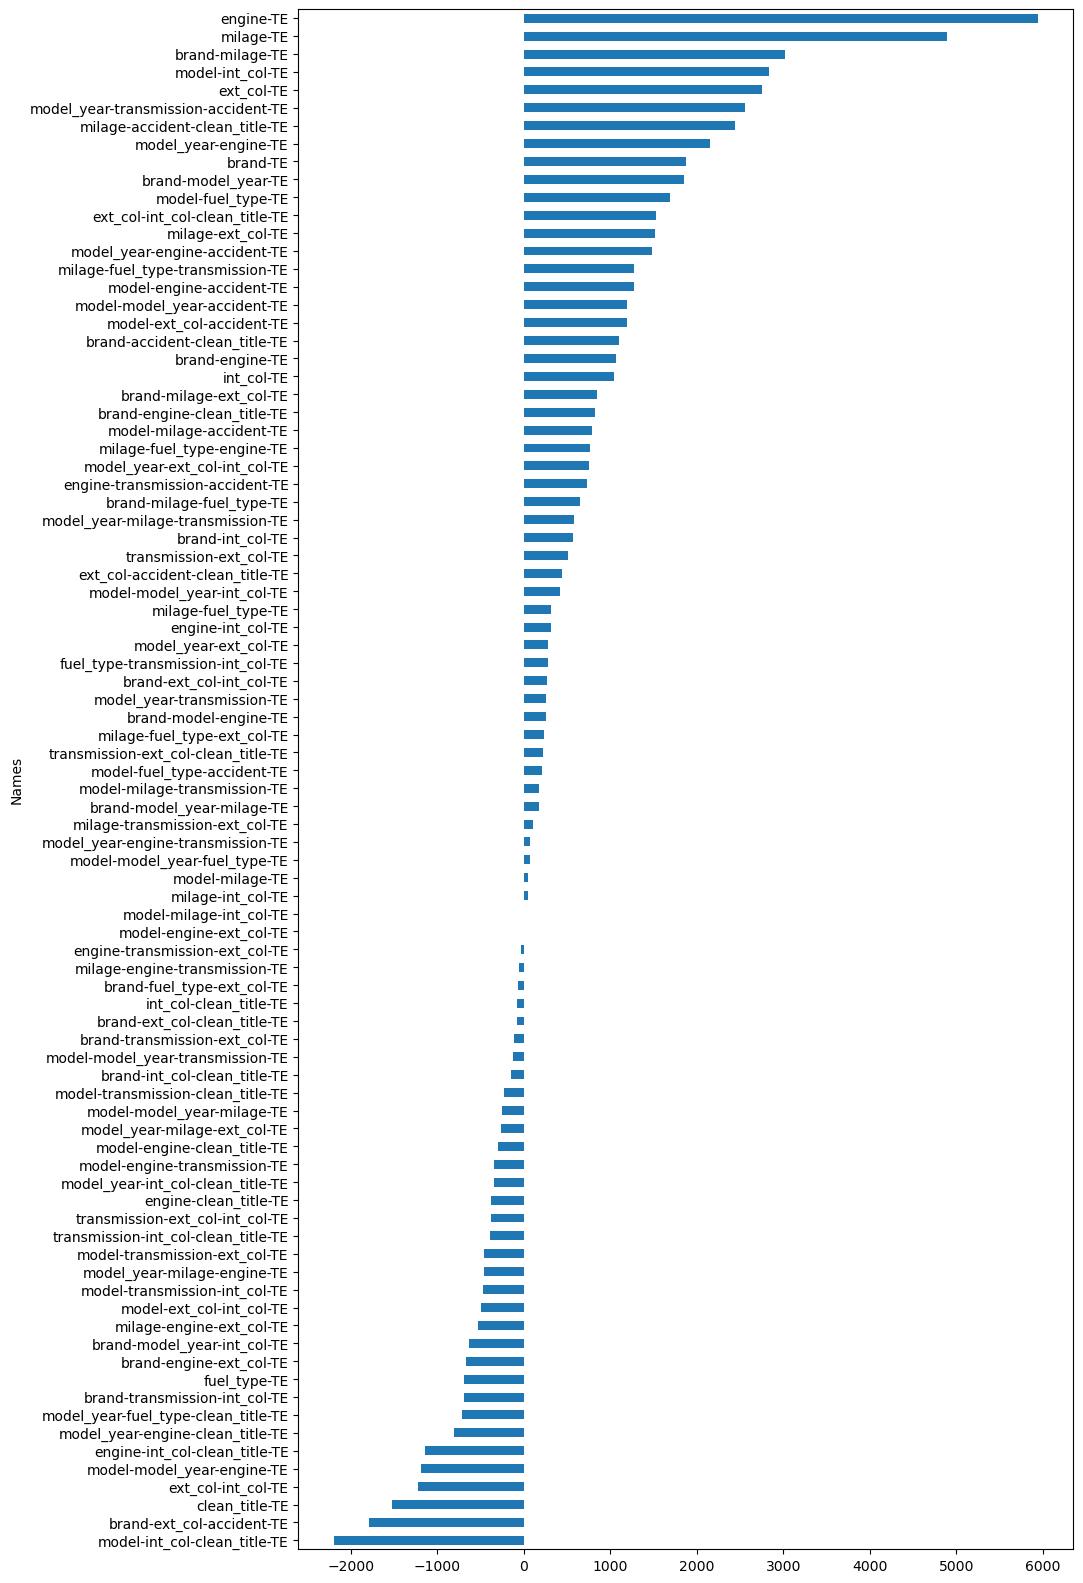

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
data = {'Names': TE_COLS,
        'Numbers': model.coef_.to_numpy()}

# Create a DataFrame
df = pd.DataFrame(data)
df = df.sort_values("Numbers", ascending=True)
df = df.loc[df.Numbers != 0]

# Create a horizontal bar plot
df.plot(x='Names', y='Numbers', kind='barh', legend=False, figsize=(10, 20))

# Show the plot
plt.show()